In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels
import statsmodels.formula.api as smf

### **RCT on synthetic data**

Preliminary functions

Simulation of a linear model

In [2]:
def linear_simulation(n, sigma, p):
  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n) # mean, std, n
  T=np.random.binomial(1, p, n)
  Y= 3 * X1+ 2 * X2 - 2 * X3 - 0.8 * X4 + T * (2 * X1+ 5 * X3 + 3 * X4) + epsilon
  d=np.array([T, X1, X2, X3, X4, Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y']) 
  return df_data 

In [3]:
df_data_linear=linear_simulation(1000, 1.0, 0.5)
df_data_linear

,T,X1,X2,X3,X4,Y
0,1.0,0.666749,1.079966,2.160928,0.544501,13.327897
1,0.0,0.364461,1.662603,2.970864,0.667599,-2.422283
2,0.0,0.817405,0.925190,-0.962750,-0.818448,6.768815
3,1.0,0.701064,0.451339,0.420425,0.841974,7.973556
4,1.0,0.294284,1.586945,2.041487,-1.479882,6.568205
...,...,...,...,...,...,...
995,0.0,1.013216,-0.053312,-1.596314,2.720668,3.601656
996,0.0,1.625997,-0.323190,0.666007,-0.925112,3.930111
997,0.0,2.126841,2.211262,0.621271,1.105185,8.480837
998,0.0,2.734820,0.694465,1.922659,1.728001,3.924829


Simulation of a non linear model

In [4]:
def non_linear_simulation(n,sigma,p):
  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T = np.random.binomial(1, p, n)
  Y = 3 * X1 + 2 * X2**2 - 2 * X3 - 0.8 * X4 + 10 * T + epsilon
  d=np.array([T, X1, X2, X3, X4, Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y']) 
  return df_data 

In [21]:
df_data_non_linear=non_linear_simulation(1000, 1.0, 0.5)
df_data_non_linear

,T,X1,X2,X3,X4,Y
0,1.0,0.473654,0.312614,1.725605,1.193661,6.435952
1,1.0,0.994366,0.355609,0.158336,2.629683,11.325636
2,1.0,0.094733,0.478974,0.481054,1.121785,9.261181
3,0.0,1.564602,0.338488,0.303010,2.263174,3.069621
4,0.0,0.263846,1.228767,-0.679093,1.872129,3.412540
...,...,...,...,...,...,...
995,0.0,1.076707,1.024838,2.014446,-0.445863,1.592353
996,0.0,0.552933,0.637810,-0.125239,0.452383,3.382534
997,0.0,1.047810,1.179636,0.293926,-0.287179,7.241437
998,1.0,0.724100,0.354008,0.855349,0.867880,10.409375


Question 1

In [6]:
def difference_in_means(df_data,alpha):
  # Filter treatment / control observations, pulls outcome variable as a vector
  Y0=df_data[df_data['T']==0]['Y']
  Y1=df_data[df_data['T']==1]['Y']
  # Number of obs in control group
  n0=len(Y0)
  # Number of obs in treatment group
  n1=len(Y1)
  # Difference in means is ATE
  tauhat=np.mean(Y1)-np.mean(Y0)
  # 95% Confidence intervals
  se_hat = np.sqrt(np.var(Y0)/n0 + np.var(Y1)/n1)
  lower_ci = tauhat - norm.ppf(1-alpha/2)* se_hat
  upper_ci = tauhat + norm.ppf(1-alpha/2) * se_hat
  return tauhat, lower_ci, upper_ci


In [7]:
alpha = 0.05
tauhat, lower_ci, upper_ci = difference_in_means(df_data_linear, alpha)
print(f"For linear generative model, the estimated ATE is {tauhat}; with a {(1-alpha)*100}% confidence interval [{lower_ci}, {upper_ci}]")

For linear generative model, the estimated ATE is 9.314669345568861; with a 95.0% confidence interval [8.607672738397088, 10.021665952740634]


In [8]:
alpha = 0.05
tauhat, lower_ci, upper_ci = difference_in_means(df_data_non_linear, alpha)
print(f"For non-linear generative model, the estimated ATE is {tauhat}; with a {(1-alpha)*100}% confidence interval [{lower_ci}, {upper_ci}]")

For non-linear generative model, the estimated ATE is 10.658991536830744; with a 95.0% confidence interval [9.910181080618786, 11.407801993042701]


Question 2

Question 2.1

Under the assumptions of RCT

$\mathbb{E}[Y | T = 0] = \mathbb{E}[3X_1 + 2X_2 + −2X_3 − 0.8X_4 ]$

$\mathbb{E}[Y | T = 1] = \mathbb{E}[3X_1 + 2X_2 + −2X_3 − 0.8X_4 + (2X_1 + 5X_3 + 3X_4 )]$

Hence

$\mathbb{E}[Y | T = 1] -\mathbb{E}[Y | T = 0] =\mathbb{E}[2X_1 + 5X_3 + 3X_4 ]=2\mathbb{E}[X_1]+5\mathbb{E}[X_3]+3\mathbb{E}[X_4]=10$

The derivations also give 10 for the non linear model.

Question 2.2

We use a Welch Two Sample t-test. It is relevant in case of large distributions because of the CLT (here we shall for example consider the case $n=1000$)

In [9]:
Y0l=df_data_linear[df_data_linear['T']==0]['Y']
Y1l=df_data_linear[df_data_linear['T']==1]['Y']
stats.ttest_ind(a=Y0l, b=Y1l,equal_var = False)

Ttest_indResult(statistic=-25.796026537699856, pvalue=1.6418842228058752e-106)

We conclude that the group control and group treatment have two diffrent distributions

Non linear case

In [10]:
Y0nl=df_data_non_linear[df_data_non_linear['T']==0]['Y']
Y1nl=df_data_non_linear[df_data_non_linear['T']==1]['Y']
stats.ttest_ind(a=Y0nl, b=Y1nl,equal_var = False)

Ttest_indResult(statistic=-27.87124565983689, pvalue=1.1046124221081288e-126)

Same conclusion

Question 3

In [17]:
def difference_in_condmean_ols(df_data,alpha):
  df_data_cond = df_data.drop(labels="T", axis=1)
  df_data_X = df_data_cond.drop(labels="Y", axis=1)
  df_data_cond0 = df_data_cond[df_data['T']==0]
  df_data_cond1 = df_data_cond[df_data['T']==1]

  model0 = smf.ols(formula='Y ~ X1 + X2 + X3 + X4', data=df_data_cond0)
  model1 = smf.ols(formula='Y ~ X1 + X2 + X3 + X4', data=df_data_cond1)
  # Fit the two modesl
  result0 = model0.fit()
  result1 = model1.fit()
  #Coefficients
  beta0=result0.params
  beta1=result1.params
  # Predict using all observations, the treated and the control
  # Difference in predicted means is ATE 

  df_data_X['cst'] = 1

  tauhat = np.mean(result1.get_prediction(df_data_X).predicted_mean) - np.mean(result0.get_prediction(df_data_X).predicted_mean)
  

  # 95% Confidence intervals
  ## Extract all the needed quantities 
  df_Y=df_data['Y']
  n=len(df_Y)
  Y0=df_data[df_data['T']==0]['Y']
  Y1=df_data[df_data['T']==1]['Y']
  # Number of obs in control group
  n0=len(Y0)
  # Number of obs in treatment group
  n1=len(Y1)
  ## compute the se
  var_DM = np.var(Y0)/n0 + np.var(Y1)/n1 # It is not true var_DM, It is "var_DM / (n0+n1)"
  var_OLS = var_DM - ((beta0[1:].values+beta1[1:].values).T @ np.cov(df_data_X)[0:4,0:4].T @ (beta0[1:].values+beta1[1:].values))/(n0+n1)
  se_hat=np.sqrt(var_OLS)
  lower_ci = tauhat - norm.ppf(1-alpha/2)* se_hat
  upper_ci = tauhat + norm.ppf(1-alpha/2) * se_hat

  return tauhat,lower_ci, upper_ci
  


In [14]:
alpha = 0.05
tauhat,lower_ci, upper_ci=difference_in_condmean_ols(df_data_linear, alpha)
print(f"For linear generative model, the estimated ATE is {tauhat}; with a {(1-alpha)*100}% confidence interval [{lower_ci}, {upper_ci}]")

For linear generative model, the estimated ATE is 9.737804229000881; with a 95.0% confidence interval [9.265760546852245, 10.209847911149517]


In [22]:
alpha = 0.05
tauhat,lower_ci, upper_ci=difference_in_condmean_ols(df_data_non_linear, alpha)
print(f"For non linear generative model, the estimated ATE is {tauhat}; with a {(1-alpha)*100}% confidence interval [{lower_ci}, {upper_ci}]")

For non linear generative model, the estimated ATE is 10.207894693668614; with a 95.0% confidence interval [9.56407617343741, 10.851713213899817]


Question 4

In [23]:
alpha = 0.05
tauhat_DM_l = []
tauhat_OLS_l = []
for _ in range(100):
    df_data_linear=linear_simulation(1000, 1.0, 0.5)
    tauhat_DM, _, _ = difference_in_means(df_data_linear, alpha)
    tauhat_OLS, _, _ = difference_in_condmean_ols(df_data_linear, alpha)
    tauhat_DM_l.append(tauhat_DM)
    tauhat_OLS_l.append(tauhat_OLS)


<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(var_OLS)
<ipython-input-17-62ac71a5acd8>:36: RuntimeWarning: invalid value encountered in sqrt
  se_hat=np.sqrt(v

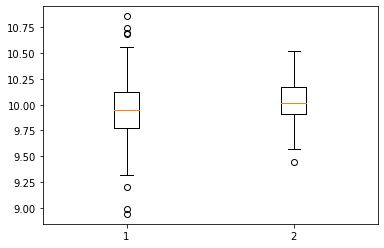

In [24]:
import matplotlib.pyplot as plt
plt.boxplot([tauhat_DM_l, tauhat_OLS_l])
plt.show()

The variance of OLS estimator is smaller than DM.